# <center>Deep Learning Assignment 1</center>

### Setting up the Notebook

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import tempfile


In [2]:
print(f'Default GPU Device:{tf.test.gpu_device_name()}')

Default GPU Device:/device:GPU:0


In [3]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# shutil.rmtree(logdir, ignore_errors=True)

# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# # Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/models

### Exploratory Data Analysis

In [4]:
data = pd.read_csv("data.csv")

In [5]:
data.head(5)

,View1,View2,View3,View4,label
0,Image_000001_001.jpg,Image_000001_002.jpg,Image_000001_003.jpg,Image_000001_004.jpg,airplane
1,Image_000002_001.jpg,Image_000002_002.jpg,Image_000002_003.jpg,Image_000002_004.jpg,airplane
2,Image_000003_001.jpg,Image_000003_002.jpg,Image_000003_003.jpg,Image_000003_004.jpg,airplane
3,Image_000004_001.jpg,Image_000004_002.jpg,Image_000004_003.jpg,Image_000004_004.jpg,airplane
4,Image_000005_001.jpg,Image_000005_002.jpg,Image_000005_003.jpg,Image_000005_004.jpg,airplane


In [6]:
data.shape

(30530, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30530 entries, 0 to 30529
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   View1   30530 non-null  object
 1   View2   30530 non-null  object
 2   View3   30530 non-null  object
 3   View4   30530 non-null  object
 4   label   30530 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


* no null values for the fields
* 4 images per view for each label

In [8]:
last_column = data["label"]
print(f"There are {len(last_column.unique())} classes for this dataset")

There are 20 classes for this dataset


In [9]:
last_column

0        airplane
1        airplane
2        airplane
3        airplane
4        airplane
           ...   
30525         bus
30526         bus
30527         bus
30528         bus
30529         bus
Name: label, Length: 30530, dtype: object

In [10]:
label_dict = {v: k for v, k in enumerate(np.unique(last_column))}
label_dict

{0: 'airplane',
 1: 'bathtub',
 2: 'bench',
 3: 'bottle',
 4: 'bus',
 5: 'cabinet',
 6: 'car',
 7: 'chair',
 8: 'display',
 9: 'faucet',
 10: 'guitar',
 11: 'jar',
 12: 'lamp',
 13: 'laptop',
 14: 'loudspeaker',
 15: 'rifle',
 16: 'sofa',
 17: 'table',
 18: 'telephone',
 19: 'watercraft'}

Plot the data distribution 

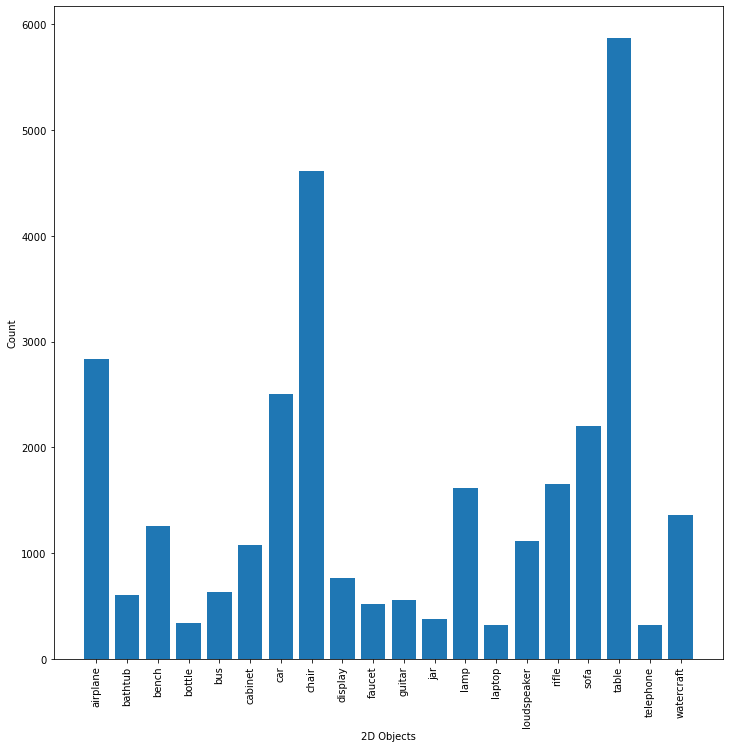

In [11]:
labels, counts = np.unique(last_column, return_counts=True)
plt.figure(figsize=(12, 12))
plt.bar(labels, counts, align='center', )
plt.xlabel('2D Objects')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

* unbalanced data distrubtion across the 20 classes
* classes such as car and table which has much more data points than rest of the classes

In [12]:
result = [x for x in data['View1']]
len(result)

30530

* Using Hold out validaiton for this problem because this is simplaer to setup
* the split ratio is 80:20, train has 80% and validaiton has 20% of the data

In [13]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(data, test_size=0.2)

In [14]:
c = []
for index, row in data.iterrows():
    c.append([row['View1'], row['View2']])



### Custom Data Loader for this Assignment

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
class CustomDataLoader(tf.keras.utils.Sequence):
    def __init__(self, dataFrame, batch_size, labels, shuffle, augment, std, mean ,data_prefix="", dim=(4, 64, 64, 3), singleView=False):
        self.batch_size = batch_size
        self.labels = labels
        self.augment = augment
        self.singleView = singleView
        
        self.dim = dim
    
        self.dataFrame = dataFrame.copy()
        self.image_label = le.fit_transform(dataFrame['label'])
        self.image_ids = np.arange(len(self.image_label)).tolist()
        self.data_prefix = data_prefix
        self.shuffle = shuffle

        self.std = std
        self.mean = mean
        self.q = True
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in idx]
        image_label_temp = [self.image_label[k] for k in idx]
        # Generate data
        X, y = self.__data_generation(data_ids_temp, image_label_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self,  data_ids_temp, image_label_temp):

        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size))
        
        for i, ids in enumerate(data_ids_temp):
            X[i, ]  = self.__read_data_instance(data_ids_temp[i])
            y[i] = image_label_temp[i]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.labels)
    

    def __read_data_instance(self, pid):
        filePaths = [self.data_prefix + x for x in self.dataFrame.iloc[pid] if x != self.dataFrame.iloc[pid]['label']]
        
        images = [Image.open(f) for f in filePaths]
        images = [np.asarray(image) for image in images]

        X = [(image - self.mean) / self.std for image in images]
        if self.singleView:
            if self.q == True:
                print(X[0].shape)
                self.q = False
            return X[0]
        return X
        

### Checking if Data Loader works

In [26]:
mean = 0
std = 255.0

prefix = 'data/Train/'
train_g = CustomDataLoader(train, batch_size=128, mean=0, std=std, labels=20, data_prefix=prefix, shuffle=True, augment=False, singleView=True, dim=(64,64,3))
val_g = CustomDataLoader(validation, batch_size=128, mean=0, std=std, labels=20, data_prefix=prefix, shuffle=True, augment=False, singleView=True, dim=(64,64,3))

### Plot some images with labels for the first batch

(64, 64, 3)


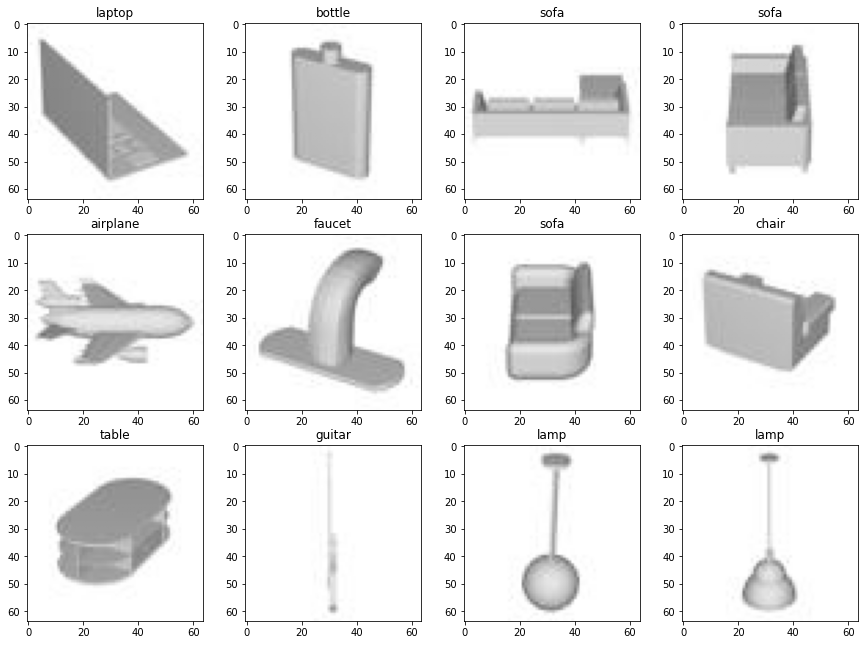

In [27]:
from PIL import Image
x, y = next(train_g.__iter__())
fig = plt.figure(figsize=(15, 11))

for i in range(12):
    fig.add_subplot(3, 4, i + 1)
    plt.imshow(x[i])
    plt.title(label_dict[np.argmax(y[i])])


## Determine the goal


Using a tiny model to see if the network is indeed working

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, MaxPooling3D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
import tensorflow_addons as tfa

def getTinyModel():
  model = Sequential()
  # input layer
  model.add(Input(shape=(64, 64, 3)))

  # Conv Layer 1
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # MLP
  model.add(Flatten())
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dense(20))
  model.add(Activation('softmax'))

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False),
                metrics=[tfa.metrics.F1Score(num_classes=20, average='macro')])
                
  return model


In [50]:
tinyModel = getTinyModel()
history = tinyModel.fit(train_g, epochs=10)


Epoch 1/10
190/190 [==============================] - 416s 2s/step - loss: 2.0867 - f1_score: 0.1473
Epoch 2/10
190/190 [==============================] - 102s 539ms/step - loss: 1.1995 - f1_score: 0.4714
Epoch 3/10
190/190 [==============================] - 51s 268ms/step - loss: 0.9650 - f1_score: 0.6108
Epoch 4/10
190/190 [==============================] - 52s 272ms/step - loss: 0.8571 - f1_score: 0.6557
Epoch 5/10
190/190 [==============================] - 43s 228ms/step - loss: 0.7698 - f1_score: 0.6917
Epoch 6/10
190/190 [==============================] - 50s 263ms/step - loss: 0.7014 - f1_score: 0.7175
Epoch 7/10
190/190 [==============================] - 238s 1s/step - loss: 0.6523 - f1_score: 0.7273
Epoch 8/10
190/190 [==============================] - 49s 260ms/step - loss: 0.6021 - f1_score: 0.7492
Epoch 9/10
190/190 [==============================] - 48s 253ms/step - loss: 0.5490 - f1_score: 0.7690
Epoch 10/10
190/190 [==============================] - 48s 251ms/step - loss

## Transfer Learning 

### Develop a baseline model
Use pre-trained ResNet50 for classiying single view

freeze the trained layers for the model

In [44]:
baseModel = tf.keras.applications.ResNet50(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               classes=20)
baseModel.trainable = False

Adding a classification layer for our dataset

In [51]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = baseModel(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(20, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tfa.metrics.F1Score(num_classes=20, average='macro')])


In [53]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem_5   (None, 64, 64, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [54]:
history = model.fit(train_g, epochs=10, verbose=1, validation_data=val_g)

Epoch 1/10
190/190 [==============================] - 284s 1s/step - loss: 2.7822 - f1_score: 0.0250 - val_loss: 2.6311 - val_f1_score: 0.0172
Epoch 2/10
190/190 [==============================] - 537s 3s/step - loss: 2.6086 - f1_score: 0.0176 - val_loss: 2.6130 - val_f1_score: 0.0194
Epoch 3/10
190/190 [==============================] - 478s 3s/step - loss: 2.5846 - f1_score: 0.0182 - val_loss: 2.5859 - val_f1_score: 0.0214
Epoch 4/10
 72/190 [==========>...................] - ETA: 5:25 - loss: 2.5744 - f1_score: 0.0217

KeyboardInterrupt: 

## Hyperparameter Tuning

## Model Evaluation